**Machine Learning Basic Principles 2018 - Data Analysis Project Report**

# *Music genres classification: From the lenses of Neural networks and K-nearest-neighbours* 

## Abstract

*The project addresses the challenge of music genres classification with various applications in the music streaming industry, which is closely tied to user experience and loyalty to the platform, hence network effect and profit. This report will first provide the background and motivation of the challenge, then a basic analysis of typical features to be looked at in songs and popularity level of different genres. The **main goal** is to construct two machine learning classifiers that will effectively predict song genres based on these features using the methods of Neural networks and K-nearest-neighbour with model accuracy higher than 50% and log loss for the right genre no higher than 0.54. Comparision and application of the two methods will be discused at the end for better approach to the challenge.*


## 1. Introduction

*Classification is a major goal of machine learning with a wide range of industry applications. In this challenge, the spotlight is on the profit-grossing and highly fragmented music streaming industry with notable players such as Youtube, Spotify, Deezer, Soundcloud, etc. whose content recommendation plays a large role in the music experience of users and helps sustaining and growing the userbase. User taste is subjective and volatile, just as the philosophy behind song recommendations is varied. Some platforms distinguish more between genres, labels, artists; some bundle and mix genres; some are more precise and safer, and some are bolder and more exploratory in their suggestions leading users to some amazing musical esoteric wild-land. All of this is done while pulling data from users’ listening history and feeding it through some algorithms. These multifaceted practices illicit different responses from and caters for the preferences of most users, but before more creative approaches can be hatched, it is fundamental for each platform to possess a reasonably accurate genres classifier through continuous modelling and experimenting. A happy userbase whose needs for relevant recommendations and contents are satisfied is further endeared to the platform and helps owner generate more and more profit in this competitive landscape.*

*In this project, we attempt to build this very classifier using K-nearest-neighbour and Neural network to gain a general view of how song recommendations works and get hands-on experience building a machine learning tool using our knowledge of basic machine learning principles. We opine that this is the backbone of any song recommendations philosophy relating to the nature of the song – its compositional elements of timbre, pitch and rhythm – and the main route to other interest-relevant songs users going beyond a certain artist would take. We’re interested in the range of accuracy different classifiers fall into, the range of log loss for each class, and how a classifier can differentiate song genres with high compositional proximity or with limited observations since some genres are more popular than the others.*

## 2. Data analysis

*Before any attempt to construct the classifier, basic data analysis is required. The data provided includes three datasets: 

*1) training data with 4363 songs (observations)*

*2) train labels for these 4363 songs divided into 10 genres(classes)*

*3) testing data with 6544 songs whose labels are to be predicted after building the classifier*

Each song contains 264 features #, or dimensionalities, describing rhythm (168 features, 24 bands, 7 statistics), pitch (48 features, 12 classes, 4 statistics ) and timbre (48 features, 12 coefficients, 4 statistics). The 10 possible genres are 1 'Pop_Rock', 2 'Electronic', 3 'Rap', 4 'Jazz', 5 'Latin', 6 'RnB', 7 'International', 8 'Country', 9 'Reggae', 10 'Blues.

The class distribution of the training data shows heavy imbalance among the song classes, with Pop_Rock (Class 1) overwhelms the rest with 49.9% and the second largest genre, Electronic, (Class 2) trails at 14.2%. The remaining 8 classes don't even come close to 0.08%. This poses a serious problem and the challenge then boils down to classifying classes with far too few observations. If the testing data is distributed in the same manner and the dummy_solution is any indication, the danger of classifying everything to Class 1 with the accuracy of almost 50% is high. 
*

In [ ]:
!/usr/bin/ruby -e "$(curl -fsSL https://raw.githubusercontent.com/Homebrew/install/master/install)"
!brew install graphviz
!pip install msgpack
!pip install pydot
!pip install tensorflow
!pip install keras

In [1]:
import numpy as np
import pandas as pd
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.utils import np_utils
from keras.wrappers.scikit_learn import KerasClassifier
from keras.utils import plot_model
import sklearn.preprocessing
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
import pydot
import graphviz

/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
# fix random seed for reproducibility
seed = 7
np.random.seed(seed)
# load train and test file
Xtrain = np.genfromtxt("train_data.csv", delimiter=",")
Ytrain = np.genfromtxt("train_labels.csv", delimiter=",")
Xtest = np.genfromtxt("test_data.csv", delimiter=",")

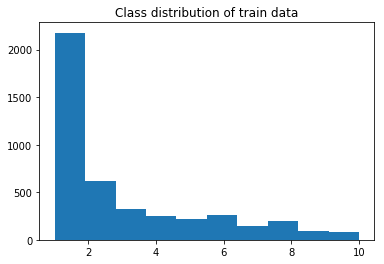

In [3]:
plt.hist(Ytrain) 
plt.title("Class distribution of train data")
plt.show()

* As it can be seen in the histogram, most of the train data is labeled with class 1 (Pop_Rock). After getting hands dirty with datasets, we are going to test the two methods: Neural networks and K nearest neighbors to compare the accuary of these two methods in solving the same datasets. In this case, we would like to test which is better.


## 3. Methods and experiments

# 3.1 Overall approach

*- Using the train data and train labels to check the model which we are going to use .* 

*- Using cross validation between train data and test data in order to predict test labels from train labels. *

*- Applying the models and checking the different accuracies of each model.*

*- Deciding what is the more suitable model.*


# 3.2 Neural networks

Neural networks can be used to extract patterns and detect trends that are too complex to be noticed by either humans or other computer techniques. Neural networks is chosen in this case because of its flexibility, not only used with regression but also classification. It is suitable to deal with the large amounts of data, with high dimension features (more than 100 features), and with the high speed of processing the prediction. 

Before running the data, we do mean normalisation and class values encoding for our dataset. The purpose of these steps are to guarantee our training run smoothly, help gradient descent converge faster and avoid local optima (purpose of mean normalisation); and create the 10 labels for 10 variables. The variables are binary variables (0 and 1) and are classified several times.

In [4]:
# mean normalization
Xtrain = sklearn.preprocessing.scale(Xtrain, axis=0)
Xtest = sklearn.preprocessing.scale(Xtest, axis=0)

# encode class values as integers
encoder = LabelEncoder()
encoder.fit(Ytrain)
encoded_Y = encoder.transform(Ytrain)
Ytrain = np_utils.to_categorical(encoded_Y, num_classes = 10)

* Next we define the model function for neural networks model using cross validation. In the definition, sigmoid activation is used so that we can get independent propabilities for each class; and dropout is also implemented to prevent overfitting.

In [ ]:
input_dim = Xtrain.shape[1]

# create model to use with cross validation
def nn_model():
    model = Sequential()
    model.add(Dense(512, input_dim=input_dim, activation='relu'))
    model.add(Dropout(0.25))
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.25))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.25))
    model.add(Dense(10, activation='sigmoid'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

# 3.2.1 Results

In [5]:
estimator = KerasClassifier(build_fn=nn_model, epochs=50, verbose=0)

# fit the model with our data
history = estimator.fit(Xtrain, Ytrain, batch_size=64)

# do cross validation
kfold = KFold(n_splits=10, shuffle=True, random_state=seed)
results = cross_val_score(estimator, Xtrain, Ytrain, cv=kfold)
print("Baseline: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))

Baseline: 63.95% (2.78%)


* Next step is to plot the graph for training accuracy and training loss

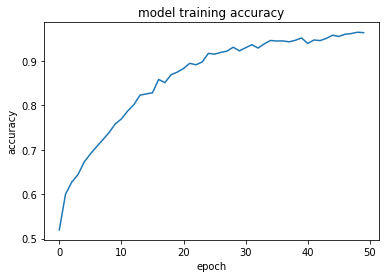

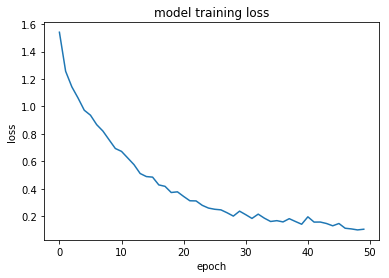

In [6]:
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.title('model training accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.savefig('training accuracy.jpg', bbox_inches='tight')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.title('model training loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.savefig('training loss.jpg', bbox_inches='tight')
plt.show()

In [7]:
# predictions for the test data
pred = estimator.predict(Xtest);
# add 1 since Python index starts from 0
fpred = pred + 1
# compare the relative ratio of predicted classes to the training set
pred[(pred == 1)].shape[0]/len(pred)
Ytrain[(Ytrain == 1)].shape[0]/len(Ytrain)
# predictions for class probabilities
prob = estimator.predict_proba(Xtest)

Below is the result of neural networks prediction for the available datasets. As it can be seen in the histogram, most of the song belong to Class 1. There are over 3500/6544 songs  in class 1, approximately 1000/6544 songs in class 2, 500/6544 songs in class 3, and the rest of the dataset are the other genres)

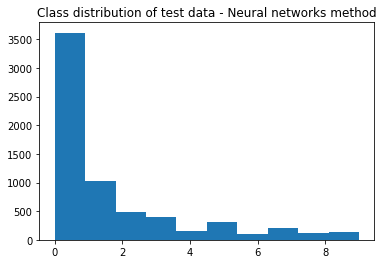

In [8]:
plt.hist(pred) 
plt.title("Class distribution of test data - Neural networks method")
plt.show()

In [9]:
# make index column
index = np.arange(1, len(pred) + 1)
index_col = np.arange(1, len(pred) + 1).reshape(len(pred), 1)

# save class predictions to file
np.savetxt("nn-accuracy.csv", np.stack((index, fpred), axis=1), fmt='%d,%d', header="Sample_id,Sample_label", comments='')

# save probabilities of class to file
header = "Sample_id,Class_1,Class_2,Class_3,Class_4,Class_5,Class_6,Class_7,Class_8,Class_9,Class_10"
fmt = '%d,%.4f,%.4f,%.4f,%.4f,%.4f,%.4f,%.4f,%.4f,%.4f,%.4f'
np.savetxt("nn-logloss.csv", np.concatenate((index_col, prob), axis=1), fmt=fmt, comments='', header=header)

Below is the visualisation of neural networks model

In [10]:
# exact same model for visualization 
model = Sequential()
model.add(Dense(512, input_dim=input_dim, activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(10, activation='sigmoid'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.fit(Xtrain, Ytrain, batch_size=64, epochs=50, verbose=0)

# visualize neural network model
plot_model(model, to_file='model.png',show_shapes = True, show_layer_names = False)


![img](model.png)

# 3.3 K-nearest neighbors

Similarity to Neural Networks, K-nearest neighbors is also the suitable and easy method to apply to both regression and classification. The strength of this method is the ability for training the large amount of data. However, the disadvantages of this method is that we have to define the value of k which brings back the best accuracy. Based on that, we can predict the test labels with the available data. 

In [ ]:
!pip install librosa
%matplotlib inline
import itertools
import scipy
import librosa
from sklearn.neighbors import KNeighborsClassifier

We would like to read the file data again to avoid conflicting with the previous method and named it "train_data_ori". In order to find the best k, we have to test on the available datasets and here are the train data and train labels. In this case, we splited the train data into train set and test set. 

In [13]:
train_data_ori=pd.read_csv('train_data.csv',header=None)
genres_index=[1,2,3,4,5,6,7,8,9,10]
train_labels=pd.read_csv('train_labels.csv', header=None)
train_data = np.hstack((train_data_ori,train_labels))

In [14]:
from sklearn.model_selection import train_test_split
test_data= pd.read_csv('test_data.csv', header=None)
test_data.shape[0]
test_labels=np.ones((test_data.shape[0],1))

number_of_cols = train_data.shape[1]
train, test = train_test_split(train_data, test_size = 0.25,random_state=3, stratify=train_data[:,number_of_cols-1])
train_x=train[:,:number_of_cols-1]
train_y=train[:,number_of_cols-1]
test_x=test[:,:number_of_cols-1]
test_y=test[:,number_of_cols-1]

print("Training data size: {}".format(train.shape))
print("Test data size: {}".format(test.shape))

Training data size: (3272, 265)
Test data size: (1091, 265)


Confusion matrix function and model function are defined.

In [15]:
def confusion_matrix(cm, classes,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
   
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

def plot_cnf(model,test_x,test_y,genres_index):
    true_y=test_y
    true_x=test_x
    prediction=model.predict(true_x)

    print("Real Test dataset labels: \n{}\n".format(true_y))
    print("Predicted Test dataset labels: \n{}".format(prediction))

    cnf_matrix=sklearn.metrics.confusion_matrix(true_y,prediction)
    plt.figure()
    a=confusion_matrix(cnf_matrix,classes=genres_index,title='Confusion matrix')

# 3.3.1 Results 

Max Accuracy is 0.548 on test dataset with 6 neighbors.



/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:16: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  app.launch_new_instance()


Training Score: 0.630
Test score: 0.772
Real Test dataset labels: 
[3 1 1 ... 1 3 1]

Predicted Test dataset labels: 
[3 1 1 ... 1 3 1]


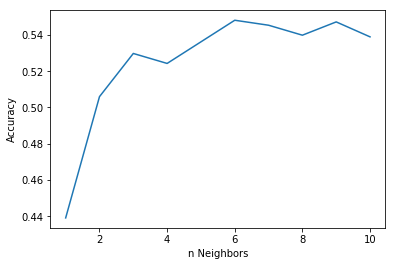

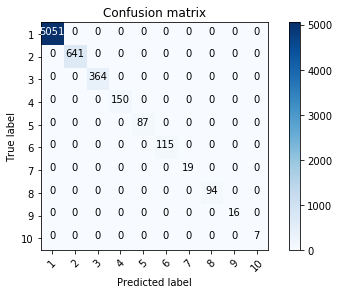

In [16]:
results_knn=[]
for i in range(1,11):
    knn=KNeighborsClassifier(n_neighbors=i)
    knn.fit(train_x,train_y)
    results_knn.append(knn.score(test_x,test_y))
    
max_accuracy_knn=max(results_knn)
best_k=1+results_knn.index(max(results_knn))
print("Max Accuracy is {:.3f} on test dataset with {} neighbors.\n".format(max_accuracy_knn,best_k))

plt.plot(np.arange(1,11),results_knn)
plt.xlabel("n Neighbors")
plt.ylabel("Accuracy")

knn=KNeighborsClassifier(n_neighbors=best_k)
knn.fit(train_data_ori,train_labels)
print("Training Score: {:.3f}".format(knn.score(train_data_ori,train_labels)))
print("Test score: {:.3f}".format(knn.score(test_data, test_labels)))  

prediction=knn.predict(test_data)
prediction
plot_cnf(knn,test_data,prediction,genres_index)

In [25]:
results1=knn.score(train_data_ori,train_labels)
print("Baseline: %.2f%% (%.2f%%)" % (results1.mean()*100, results1.std()*100))

Baseline: 62.96% (0.00%)


One thing should be noted here when log loss should not be used to evaluate k nearest neighbors. Because in this method, probabilities in nearest neighbor is dependant on the number of k. If k is higher, the log loss will be lower. However, in this case, the log loss at k=7  will be lower than the log loss at k=6. It will be conflicted with accuracy when k=6 provides the max accurary. Therefore, it is not necessary to increase k just to get the lower log loss. 

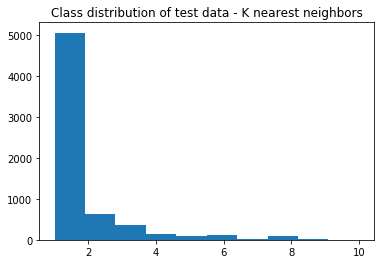

In [19]:
plt.hist(prediction) 
plt.title("Class distribution of test data - K nearest neighbors")
plt.show()

Above is the result of k nearest neighbors for the available datasets. As it can be seen in the histogram, most of the song belong to Class 1. There are about 5000/6544 songs in class 1, approximately 500/6544 songs in class 2, and the rest of the dataset are the other genres).

In [30]:
# make index column
index = np.arange(1, len(pred) + 1)
index_col = np.arange(1, len(prediction) + 1).reshape(len(prediction), 1)

# save class predictions to file
np.savetxt("knn-accuracy.csv", np.stack((index, prediction), axis=1), fmt='%d,%d', header="Sample_id,Sample_label", comments='')

## 4. Discussion

After all, we are quite satified with our results because at least they beated Kaggle benchmark. Among these two method, neural networks provided the better results with accuracy of 0.63117 and log loss of 0.54985. There is no log loss result from k nearest neighbors method and the accuray of this method is 0.548. That is the reason why there are still many rooms to improve in the further researches. It is suggested to check the balance of the dataset before choosing the most suitable method. Definitely we should try the other methods to find the best models for this genres classification issue.

## 5. References

* 1. Neural Networks. Availablet at: https://skymind.ai/wiki/neural-network
* 2. K Nearest Neighbor. Availablet at: https://kevinzakka.github.io/2016/07/13/k-nearest-neighbor/?fbclid=IwAR3MThEu6ZhdV55UxIH6JCyL_0xGuu_mtqtGIW6-HWVhhfWeUW7R-Xr211s#introduction
* 3. Why log loss metric shouldnt be used to evaluate nearest neighbors classification. Availablet at: https://medium.com/@bengikoseoglu/why-log-loss-metric-shouldnt-be-used-to-evaluate-nearest-neighbour-classification-1fe314f460a2